# This version focuses on activations, gradients, and batch normalization

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline 

In [2]:
words = open('names.txt', 'r').read().splitlines()

Vocabulary of chars

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

Building the dataset

In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


Revisiting the MLP

In [5]:
n_embd = 10 # dimensionality of the char embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g)
b2 = torch.randn(vocab_size,                    generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

Optimization

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8341
  20000/ 200000: 2.5523
  30000/ 200000: 2.8717
  40000/ 200000: 2.0855
  50000/ 200000: 2.5842
  60000/ 200000: 2.4150
  70000/ 200000: 2.1321
  80000/ 200000: 2.3674
  90000/ 200000: 2.3077
 100000/ 200000: 2.0464
 110000/ 200000: 2.4816
 120000/ 200000: 1.9383
 130000/ 200000: 2.4820
 140000/ 200000: 2.1662
 150000/ 200000: 2.1765
 160000/ 200000: 2.0685
 170000/ 200000: 1.7901
 180000/ 200000: 2.0546
 190000/ 200000: 1.8380


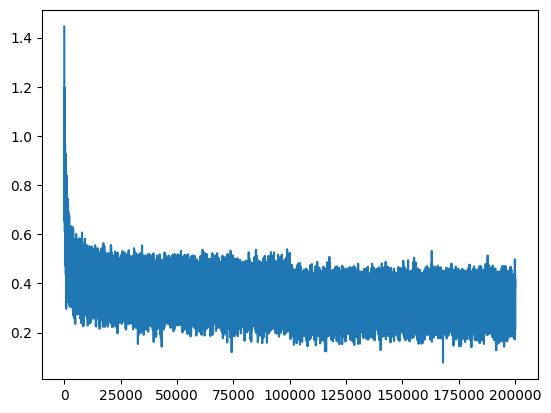

In [7]:
plt.plot(lossi)
plt.show()

Validate any data split

In [ ]:
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.125401020050049
val 2.1713311672210693


Inference

In [11]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nah.
yam.
rensleighdrae.
caileed.
elin.
shy.
jen.
eden.
estanaraelyn.
malke.
cayshuberlyni.
jest.
jair.
jenipanthono.
ubelleda.
kylynn.
els.


# -------------------------------------------------------------

# Makemore 3

Looking at our training loss, we notice that the loss is initially way too high, though it drops sharply. This implies the initialization is faulty.


We have 27 chars at initialization that can come next for any training example. There's no reason to believe any chars are much more likely than others. 
So we expect the prob distribution to be uniform, assigning that equal prob to all chars. 

We can sort of calculate the expected loss below

In [12]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

What this tells us is that the neural net is already assigning high confidence to some chars and is confidently wrong. Thus the very high loss. Consider the example below

In [13]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-0.4332, -1.1346,  1.1414, -0.6809]),
 tensor([0.1407, 0.0698, 0.6796, 0.1099]),
 tensor(0.3863))

This is kind of fine because torch.randn gives a normally distributed sample. But if we multiply these logits by a high number, our loss explodes

In [16]:
logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 12.8930, -14.9482, -88.2869,  91.3449]),
 tensor([8.4873e-35, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 tensor(inf))

So normally, we want our logits to be initially 0 so the initialisation is smooth. Something like logits = torch.tensor([0.0, 0.0, 0.0, 0.0])

Let's go back to our training loop 

In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 27.8817


and looking into the logits, we see very extreme values

In [7]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

these create the fake confidence in our network initialisation and make the loss very high

To make the logits coming out of the net to be closer to 0

Since logits = h @ W2 + b2, we don't need our bias to be randn, so we can set it to 0. Secondly, we can scale down our W2. Note that we target only the values that affect the logits

In [11]:
n_embd = 10 # dimensionality of the char embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.1857
  10000/ 200000: 1.8700
  20000/ 200000: 1.9252
  30000/ 200000: 2.0570
  40000/ 200000: 2.2073
  50000/ 200000: 2.1325
  60000/ 200000: 2.1533
  70000/ 200000: 2.8029
  80000/ 200000: 2.6544
  90000/ 200000: 2.2931
 100000/ 200000: 2.2813
 110000/ 200000: 1.8629
 120000/ 200000: 2.1695
 130000/ 200000: 1.9693
 140000/ 200000: 1.8043
 150000/ 200000: 2.4483
 160000/ 200000: 2.2238
 170000/ 200000: 1.7788
 180000/ 200000: 1.9207
 190000/ 200000: 2.1601


This improvement enables faster convergence, because we don't spend the early iterations 'squashing' down the weights (which is a waste), but rather go straight to optimizing our network

Although our loss now has a better start, we still have a looming problem - the activations of the hidden state, h

Taking a look at h

In [14]:
h

tensor([[ 0.8876,  0.8216,  0.4165,  ..., -1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.7455,  0.1933,  ..., -0.9690,  1.0000, -0.7181],
        [-0.9997, -1.0000, -1.0000,  ...,  0.9998,  0.6852, -1.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ...,  0.9998, -1.0000, -0.9380],
        [ 1.0000, -1.0000, -0.9994,  ..., -0.9999, -1.0000, -0.4911],
        [-1.0000, -1.0000, -1.0000,  ...,  1.0000, -0.8469, -0.9754]],
       grad_fn=<TanhBackward0>)

We notice several -1.0 and 1.0. This is due to the effect of tanh that 'compresses' values into -1.0 and 1.0. Opening up h

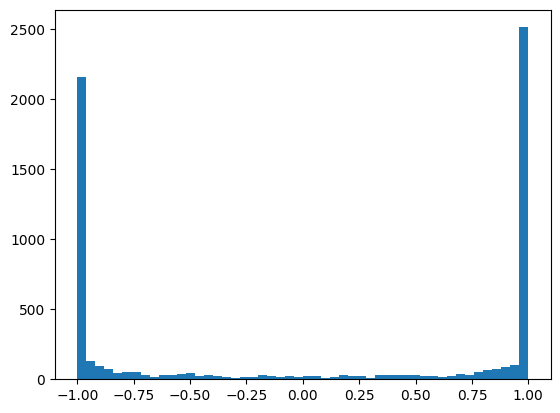

In [17]:
h_list = h.view(-1).tolist() # .view(-1) reduces the dimensionality
plt.hist(h_list, 50)
plt.show()

We can see that most of the values are either -1.0 or 1.0

We can also look at the pre-activation values

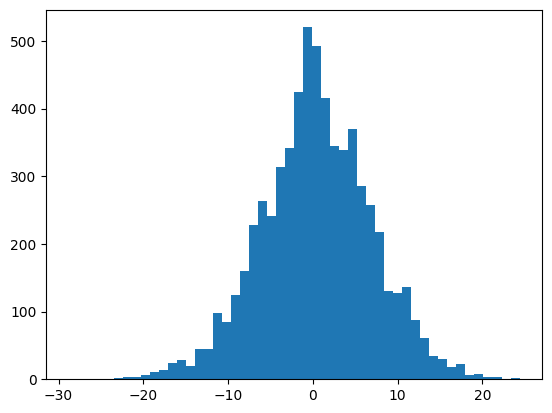

In [18]:
hpreact_list = hpreact.view(-1).tolist()
plt.hist(hpreact_list, 50)
plt.show()

# Neuron Death in Activation Functions

These extremities in h greatly affect the backpropagation. Let's look at the tanh backward() in micrograd

In [ ]:
"""""
def _backward():
    self.grad += (1 - t**2) * out.grad
"""""

With t=-1, (1 - t**2) = 0 and the grad is 0 and the gradient is essentially killed. Same thing with 1. The inputs that cause this essentially become dead inputs and no matter how you change them, they don't affect the loss

Since we have so many h values that -1 and 1, these are essentially unused in gradient computation, which gives the network a false shortcut to convergence

Let's visualize h to see how often it is in the 'dead' region

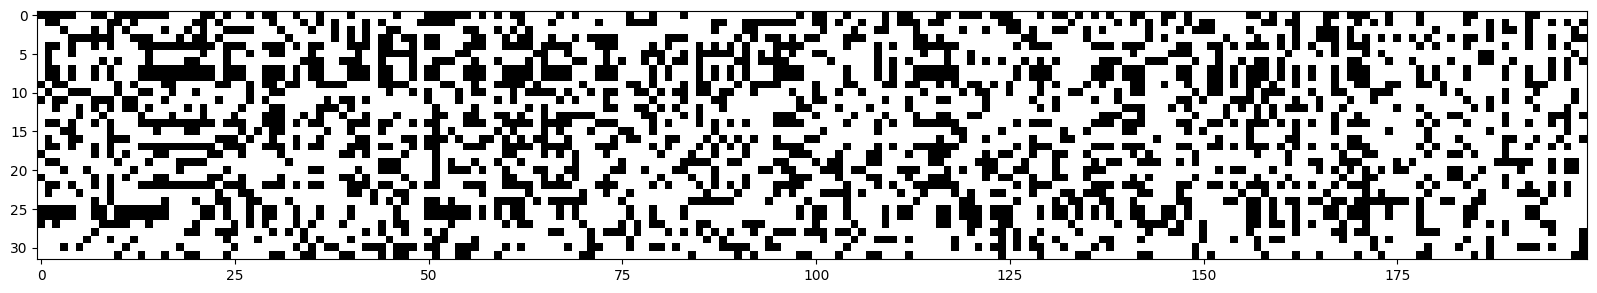

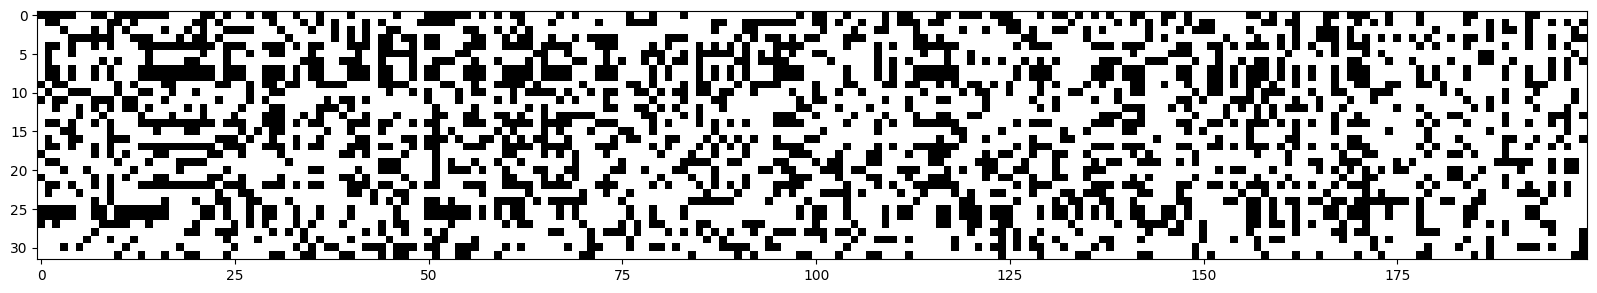

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # white if true, black if false
plt.show()

All the white areas show the neurons were very active but in the 'dead' zone, so their gradients get destroyed. However, there's no straight column that shows that the neuron was always dead meaning the neurons sometimes learn

This is true for other activation functions

 <img src='activations.png'/>

Permanent Neuron Death in Activations in Sigmoid, tanh, ReLU, and ELU

Some activations have completely flat regions. During backprop, all of the grads of the -ve preactivations are just 0. You can get a dead neuron. ie if a  neuron never activates (always in the flat region for every example), the neuron is dead and it will never get a gradient. 

It sometimes happens that in initialisation, Ws and b's just make it that some neurons are forever dead. But it can also happen at optimization that a too high learning rate makes some neurons to get too much gradient and get knocked out of being useful. From then on, no example ever activates these neurons and they remain dead forever

Leaky ReLU and Maxout

The other activations don't suffer from this because they don't have flat tails

# Fixing Dead Neurons

From our 'heatmap', we can see that we don't have permanent neuron death (no straigt column of white), but it's still not optimal

We want the preactivation to be close to 0. We can set biases to close to 0 and we can use varying numbers to introduce some sort of diversity

In [35]:
n_embd = 10 # dimensionality of the char embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [30]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3069


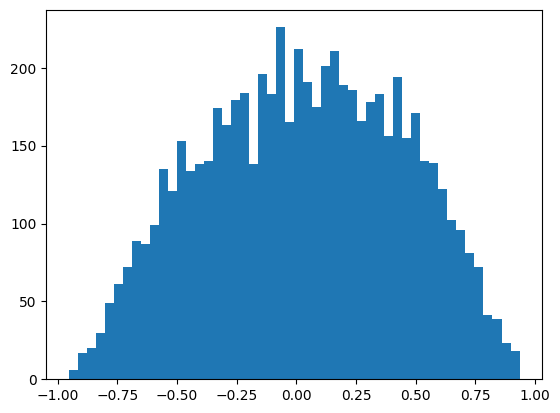

In [31]:
h_list = h.view(-1).tolist() # .view(-1) reduces the dimensionality
plt.hist(h_list, 50)
plt.show()

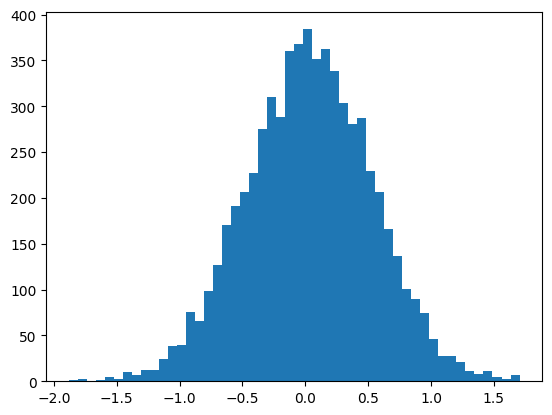

In [32]:
hpreact_list = hpreact.view(-1).tolist()
plt.hist(hpreact_list, 50)
plt.show()

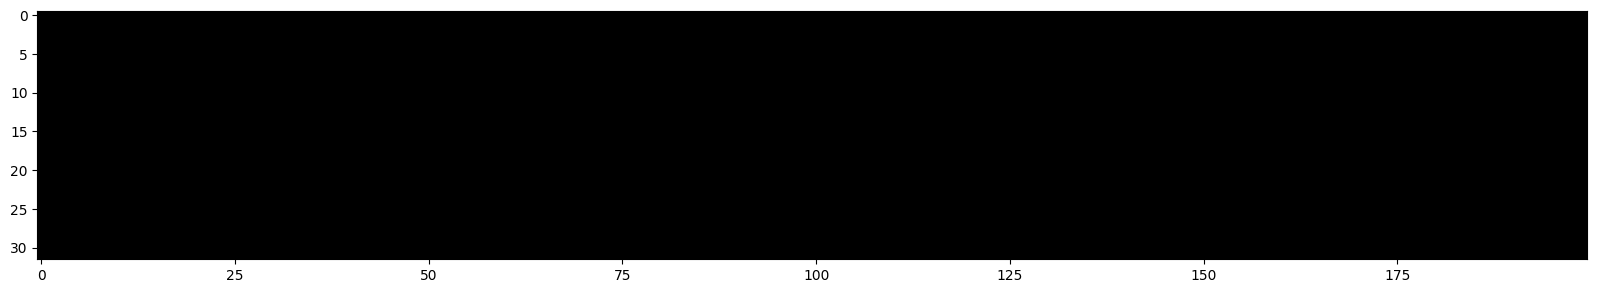

In [34]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # white if true, black if false
plt.show()

There are no more neurons above 0.99 in both directions, so we get the plot above

We can tweak W1 and re-run to see the changes

Running the optimization

In [36]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


We can re-run the validation code and see the loss has improved

# Choosing the Right Scaling Factors for W's and b's

Given some random x and w drawn from a Gaussian distribution, we get the preactivation y

In [38]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w # ignoring bias and non-linearity for now

In [39]:
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(-0.0051) tensor(1.0008)
tensor(0.0161) tensor(3.1868)


If we look at the means of x and y, we see they're kind of the same but the std has expanded. We, however, want the distribution to be uniform throughout the net. How do we preserve this Gaussian-ness?

What do we multiply w by to maintain this relationship?

Mathematically, we can divide by the square root of the fan in (the number of inps)

In [41]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # div by sqrt of 10, sqrt is basically the power of half
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(0.0088) tensor(0.9943)
tensor(0.0005) tensor(0.9988)


Kaiming init

A paper by Kaiming He (Delving Deep into Rectifiers, 2015) showed that if the forward pass is properly init, the backward pass is also approximately initialized up to a constant factor related to the size of the number of hidden neurons in early and late layers. Torch provides a function torch.nn.kaiming_normal_() ... see docs

The difficulty of using this method led to several more flexible approaches such as residual connections, normalization layers, and optimizers. These make it less important to precisely calibrate the neural net

To use the Kaiming init

In [ ]:
torch.randn(10000).std()

tensor(0.9926)

any number you multiply by the randn values becomes the std

In [44]:
(torch.randn(10000) * 0.2).std()

tensor(0.2038)

We want to set it to the Kaiming norm: std = gain / sqrt(fan_in); where gain is defined for different activations in the Torch docs. For tanh gain = 5/3

In [46]:
fan_in = n_embd * block_size
std = (5/3) / (fan_in**0.5)
std

0.3042903097250923

So we init our network

In [47]:
n_embd = 10 # dimensionality of the char embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)  # Kaiming init
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [48]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


# Batch Normalization

We have hidden states, and we don't want the preactivation to be way too small and we don't want them too large. We want a Gaussian hpreact. With batch_norm, we just take the inner states and normalize them to be Gaussian

We can explicitly standardize the activations so they are just Gaussian

In [49]:
hpreact.shape

torch.Size([32, 200])

We can straightforward calculate the mean and std

In [ ]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [52]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

According to the Ioffe 2015 paper on Batch Norm, we have hpreact = (hpreact - hpreact.mean()) / hpreact.std()



This means that the hpreact will be Gaussian on the 32 examples of the batch

In [ ]:
...

for i in range(max_steps):
    # Construct the minibatch
    ...

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # Batch norm
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
...
    # break

If we train this, we won't get good results because we want the normalization only at init. So the neural nets are not forced everytime and should learn on their own.

 This is done through a scale and shift mechanism that takes the normalized inps, scales by some gain and offset by some bias to get the final output from the layer. These two values (gain and bias) are trainable params

In [53]:
n_embd = 10 # dimensionality of the char embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)  # Kaiming init
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

Because the gain is init to 1s and the bias to 0s, at init, each neuron's firing value will be exactly unit Gaussian (basically multiply by 1 and add 0). During optimization, the gain and bias are also trained 

In [54]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # Batch norm
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias    
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


The batchnorm is also added in the evaluation step

In [56]:
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')


train 2.0668270587921143
val 2.104844808578491


We don't see so much performance gain because we are working with a very simple neural net with just one hidden layer. The effect of batch norm is not that significant in this case

Batch Norm Shortcoming

The stability of batch norm, however, comes at a cost. Since batch norm works as a batch, every sample is affected by essentially all other samples in the batch. This means that the activation of one sample gets changed depending on what other examples are in the batch. 

This property of batch norm is beneficial in training as it acts as a regularizer. It introduces some entropy or augmentation of the input, making it harder for the neural net to overfit to specific examples. 

Once we've train a neural net, we want to deploy it and feed a single example for prediction. The introduction of batch norm configures the neural net to expect batches. To do this, the paper suggests an extra post-training step to calculate in one go the mean and std over the entire training set

In [57]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure mean/std over entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

Our eval becomes

In [58]:
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')


train 2.0668270587921143
val 2.1049270629882812


Since it is not feasible to introduce this calculate explicitly after training, we can estimate mean and std in a running manner during training

In [60]:
n_embd = 10 # dimensionality of the char embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)  # Kaiming init
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# accummulating the batch norm mean and std. These don't require gradients because they're not optimized
bnmean_running = torch.zeros((1, n_hidden)) # init mean should be roughly 0
bnstd_running = torch.ones((1, n_hidden))  # and std should be roughly 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [61]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # Batch norm
    bnmean_i = hpreact.mean(0, keepdim=True)
    bnstd_i = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_i) / bnstd_i  + bnbias    

    with torch.no_grad(): # outside gradient based optimisation
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
    
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


This eliminates the explicit calculation of bnmean and bnstd 

In [62]:
@torch.no_grad() # disable gradient tracking automatically setting requires_grad to false
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')


train 2.06659197807312
val 2.1050572395324707


By adding a batch norm after calculating the bias, we essential subtract it back thus nullifying their effect. This makes them useless and it's just a waste of space. It functionality is replaced by the batch norm bias bnbias

# Summarising

In [ ]:
n_embd = 10 # dimensionality of the char embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),           generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)  # Kaiming init
# b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn(vocab_size,                    generator=g) * 0

# Batch Norm params
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden)) # init mean should be roughly 0
bnstd_running = torch.ones((1, n_hidden))  # and std should be roughly 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into a vector
    embcat = emb.view(emb.shape[0], -1) # concat the vectors

    # linear layer
    hpreact = embcat @ W1 # + b1 
    
    # batch norm layer
    bnmean_i = hpreact.mean(0, keepdim=True)
    bnstd_i = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_i) / bnstd_i  + bnbias    
    with torch.no_grad(): # outside gradient based optimisation
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
    
    # non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

In the PyTorch implementation 0.001 in 0.001 * bnmean_i is the momentum. If you have a very large batch size, the mean and std might be roughly the same throughout. You can use a larger momentum for larger batch sizes. 

# -------------------------------------------------------------------------------------------------------------------------

# PyTorch-ing the Code

In [70]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias # Wx + b if there's b
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        
class BatchNorm1d:  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # epsilon
        self.momentum = momentum
        self.training = True # behaviours of certain attributes vary for training and inference
        # batchnorm trainable params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers for running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else: # in inference, we use the accummuldated mean and var of the whole training set
            xmean = self.running_mean 
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update buffers - only updated during training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 -self.momentum) * self.running_var + self.momentum * xvar
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta] 
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

In [ ]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [ # ignore the formatting, it's just a list with elements
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

# we init before training
with torch.no_grad():
    # make softmax (last layer) less confident
    layers[-1].weight *= 0.1
    # apply gain on all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [97]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into a vector
    x = emb.view(emb.shape[0], -1) # concat the vectors
    # new forward pass for layers
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break # for debugging

      0/ 200000: 3.2962


Visualize the saturation to see the stability of the activations

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


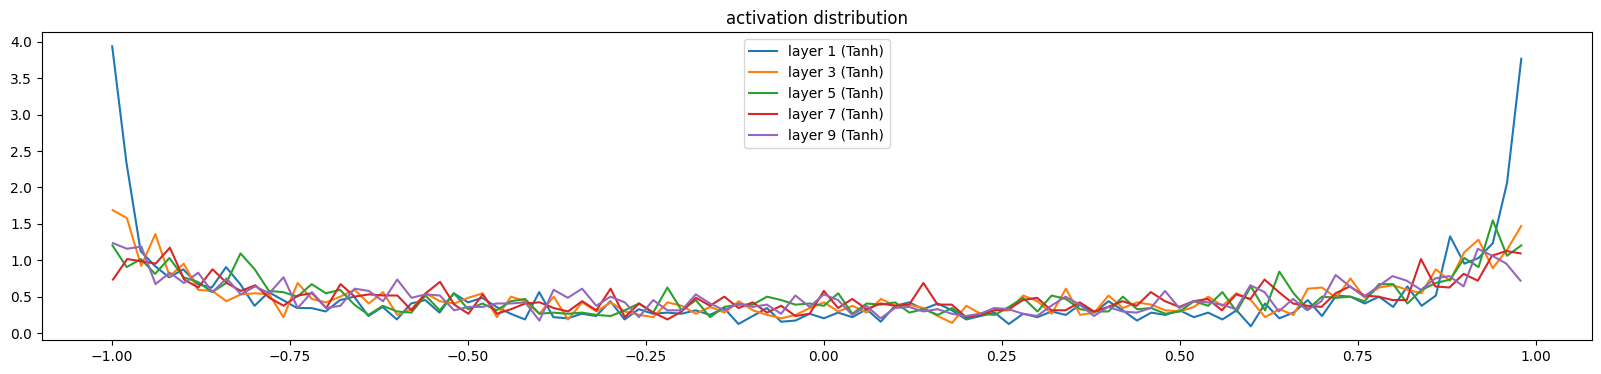

In [98]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh): # it is easier to visualize for tanh because it is in a finite region -1 to 1
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

Initial activation is somewhat unstable but later layers have a better activation distribution. This is because of the gain (5/3) set while initialising the network (recall Kaiming). If we set the gain to 1 (basically no gain since it's a mult), we get something that looks like

<img src='activation_distr.png'>

Without the gain, the std is shrinking and saturation is getting to 0. The first layer is okayish, but the others are shrinking to 0. With a sandwich of linear layers alone, the weight init will conserve the std of 1 and the tanh squash the std. A gain is therefore necessary to fight the squashing

Visualizing for the gradients

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


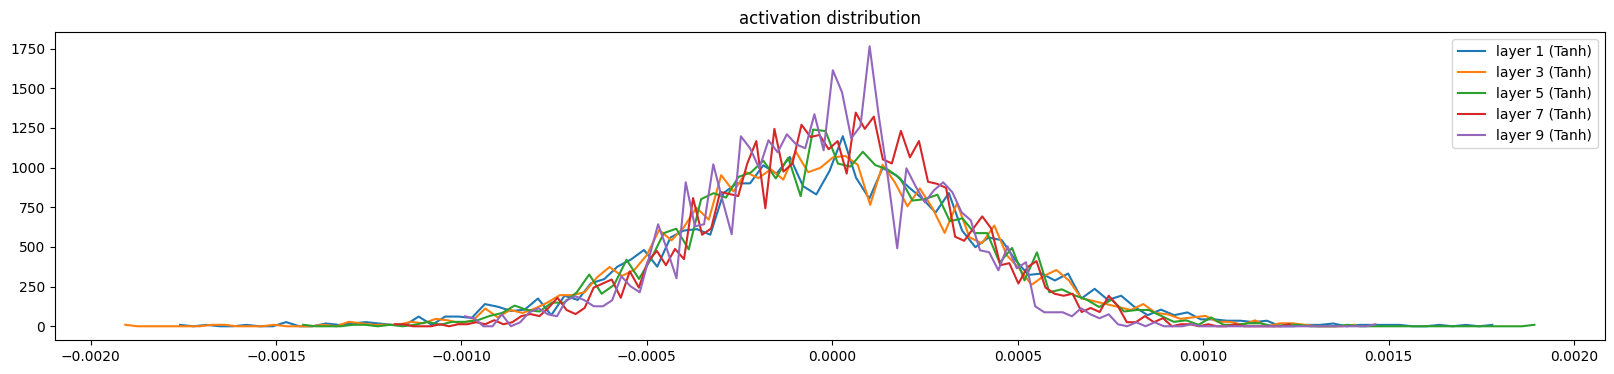

In [99]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh): # it is easier to visualize for tanh because it is in a finite region -1 to 1
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

If we remove the Tanh and leave just linearities. Your network basically becomes a very large linear approximation Wx + b. The Tanh makes a network approximate any arbitrary function

Looking at the behaviour of the weights

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


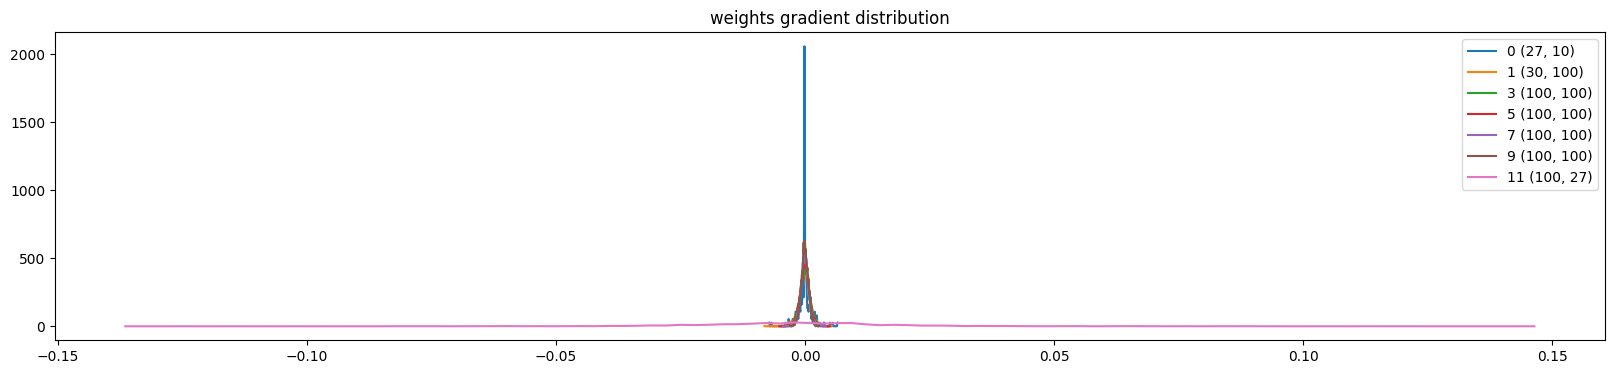

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # only for 2D weights ie linear layers, whilen ignoring weights, biases, and batch_norm params
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution')
plt.show()

The grad data ratio tells the ratio between the grads and the data. It is undesirable for grad to be too large compared to the data. But in our case, the ratio is very small unless in the last layer. The last layers' grad is around 10x greater than others, so we have to train this layer ~10x faster in a simple optimisation step like in SGD

# Update to Data Ratio - Finding a Good Learning Rate

A more important ratio to watch is the update: data ratio because it is the amount by which we change the data in the tensors. We can define it in the optimisation step

In [103]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio 
for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into a vector
    x = emb.view(emb.shape[0], -1) # concat the vectors
    # new forward pass for layers
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # for debugging

      0/ 200000: 3.2169


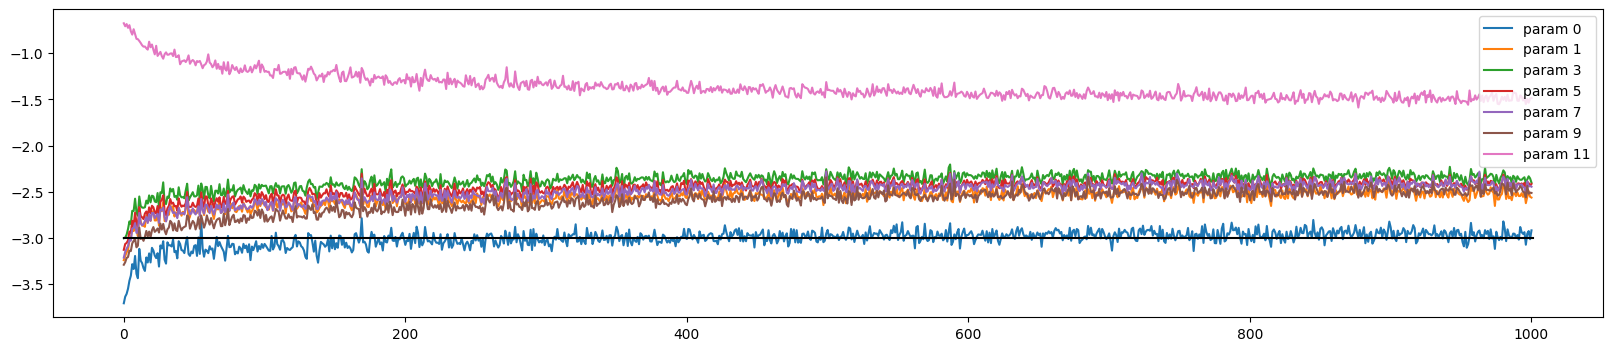

In [104]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: 
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);
# plt.title('weights gradient distribution')
plt.show()

The init takes values that then stabilize during training. The values on the higher end show there's a lot of updates. 

The final layer is an outlier because it was artificially shrunk to make softmax less confident at the init 'layers[-1].weight *= 0.1'. This made the values way too low. This however stabilises over time as the weights start to learn

Looking at the evolution of the update ratio, it's not too much below -3. Values below indicate the params are not training fast enough. A very low learning rate will be way below -3.0 

We can make plots and compare against these standard plots to see the behaviours

# Adding Batch Norm

In [110]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [ # ignore the formatting, it's just a list with elements
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), # before or after non-linearity doesn't matter
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),  
]

# we init before training
with torch.no_grad():
    # we make gamma less confident because it is the var that interacts with the output of the norm
    layers[-1].gamma *= 0.1
    # apply gain on all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [111]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio 
for i in range(max_steps):
    # Construct the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into a vector
    x = emb.view(emb.shape[0], -1) # concat the vectors
    # new forward pass for layers
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # for debugging. retains the graphs
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # for debugging

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


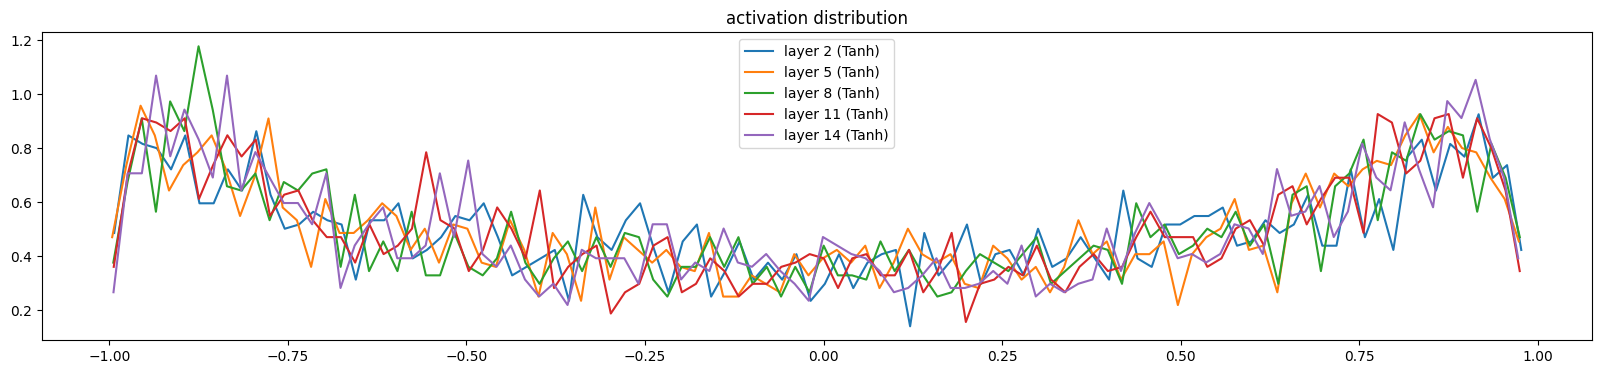

In [114]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh): # it is easier to visualize for tanh because it is in a finite region -1 to 1
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

The std is very standardized. Skipping for gradients and weights because plots don't look so different

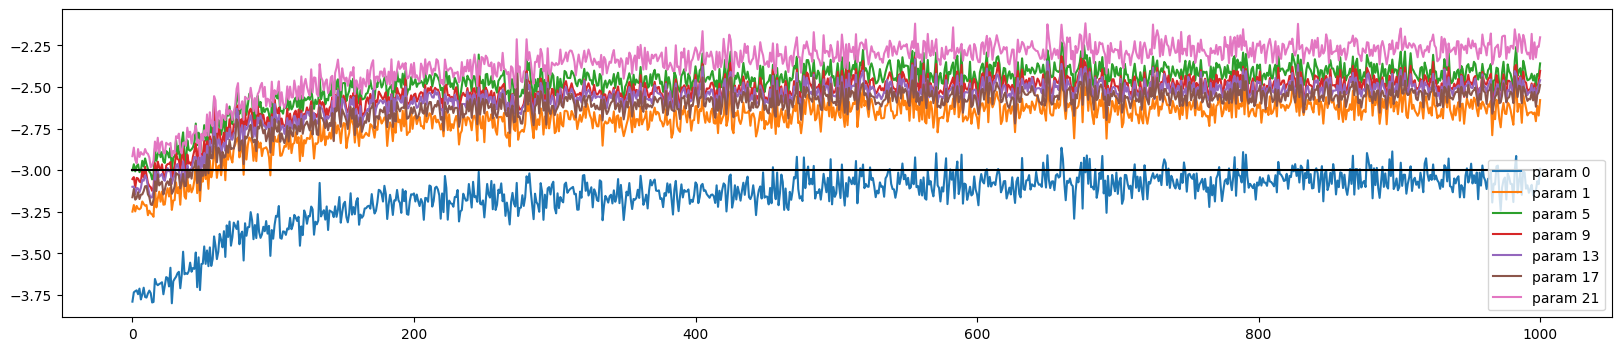

In [113]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: 
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);
# plt.title('weights gradient distribution')
plt.show()

We're going above -3 abit but not too much and params are training at roughly the same rate.